In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import re
import seaborn as sns

from styleclass.settings import STYLES
from styleclass.features import get_default_training_dataset, get_default_test_dataset, \
    clean_dataset, add_noise, generate_unknown, get_features, select_features_chi2
from styleclass.classify import evaluate_cv, evaluate_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from statistics import mean

In [2]:
training_data = get_default_training_dataset()
training_data = clean_dataset(training_data)
training_data = add_noise(training_data, random_state=0)
dataset_unknown = generate_unknown(training_data, 5000, random_state=0)
training_data = pd.concat([training_data, dataset_unknown])
print('Dataset size: {}'.format(training_data.shape[0]))

Dataset size: 87808


In [3]:
test_data = get_default_test_dataset()
test_data = clean_dataset(test_data)
test_data = add_noise(test_data, random_state=0)
dataset_unknown = generate_unknown(test_data, 5000, random_state=0)
test_data = pd.concat([test_data, dataset_unknown])
print('Dataset size: {}'.format(test_data.shape[0]))

Dataset size: 87625


In [4]:
algo_results = []
for name, algo in [('Naive Bayes', MultinomialNB()),
                   ('Logistic Regression',
                    LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0)),
                   ('Linear SVC', LinearSVC(random_state=0)),
                   ('Random Forest', RandomForestClassifier(n_estimators=200, max_depth=3,
                                                            random_state=0))]:
    accuracies, _ = evaluate_cv(training_data, algo, feature_fun=get_features,
                                feature_selector=select_features_chi2,
                                nfeatures=4600, ngrams=(2, 4), random_state=0)
    algo_results.extend([(name, fold, accuracy) for fold, accuracy in enumerate(accuracies)])
    print('Accuracy for {} algorithm {}'.format(name, mean(accuracies)))

2019-08-15 09:23:49,829 INFO Fold 0
2019-08-15 09:24:25,760 INFO Fold 1
2019-08-15 09:25:01,661 INFO Fold 2
2019-08-15 09:25:37,600 INFO Fold 3
2019-08-15 09:26:13,404 INFO Fold 4
2019-08-15 09:26:49,324 INFO Fold 0


Accuracy for Naive Bayes algorithm 0.9204032933388824


2019-08-15 09:28:28,782 INFO Fold 1
2019-08-15 09:30:05,565 INFO Fold 2
2019-08-15 09:31:53,215 INFO Fold 3
2019-08-15 09:33:43,530 INFO Fold 4
2019-08-15 09:35:31,119 INFO Fold 0


Accuracy for Logistic Regression algorithm 0.9452114410150301


Accuracy for Linear SVC algorithm 0.885774896366885


2019-08-15 10:28:15,875 INFO Fold 1
2019-08-15 10:28:59,016 INFO Fold 2
2019-08-15 10:29:42,089 INFO Fold 3
2019-08-15 10:30:25,432 INFO Fold 4


Accuracy for Random Forest algorithm 0.8284375182747186


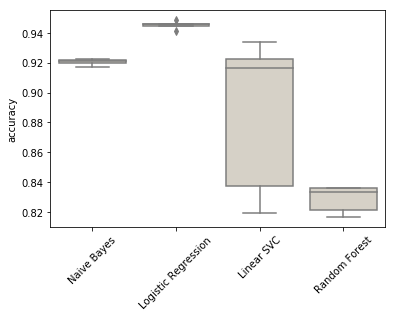

In [5]:
cv_df = pd.DataFrame(algo_results, columns=['model', 'fold', 'accuracy'])
ax = sns.boxplot(x='model', y='accuracy', data=cv_df, color="#d8d2c4")
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.savefig('images/algorithms.png', dpi=300, bbox_inches='tight')

In [6]:
accuracies, dataset_results_cv = evaluate_cv(training_data,
                                             LogisticRegression(solver='liblinear',
                                                                multi_class='ovr',
                                                                random_state=0),
                                             feature_fun=get_features,
                                             feature_selector=select_features_chi2,
                                             nfeatures=4600, ngrams=(2, 4), random_state=0)

2019-08-15 10:31:09,713 INFO Fold 0
2019-08-15 10:32:49,305 INFO Fold 1
2019-08-15 10:34:27,907 INFO Fold 2
2019-08-15 10:36:06,597 INFO Fold 3
2019-08-15 10:37:46,204 INFO Fold 4


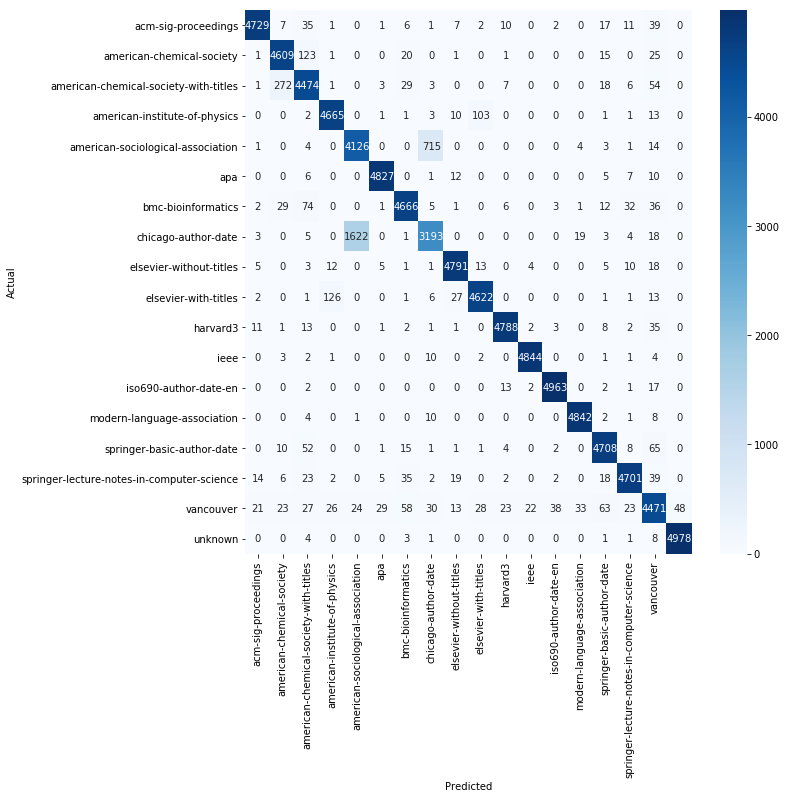

In [7]:
matrix = confusion_matrix(dataset_results_cv['style_true'], dataset_results_cv['style_pred'])

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=STYLES, yticklabels=STYLES + ['unknown'],
            cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('images/confusion_matrix.png', dpi=300, bbox_inches='tight')

In [8]:
def get_diff(actual, predicted):
    diff_df = dataset_results_cv.loc[dataset_results_cv['style_true'] == actual]
    diff_dois = diff_df.loc[diff_df['style_pred'] == predicted]['doi']
    diff_df = dataset_results_cv.loc[dataset_results_cv['doi'].isin(diff_dois)]
    diff_df = diff_df.loc[diff_df['style_true'].isin([actual, predicted])].sort_values(by='doi')
    strings = [re.sub('^\(1\)', '', re.sub('^\[1\]', '',
                                           re.sub('^1', '', re.sub('\.$', '', s)))).strip()
               for s in diff_df['string']]
    strings_0 = [s for i, s in enumerate(strings) if i%2 == 0]
    strings_1 = [s for i, s in enumerate(strings) if i%2 == 1]
    return list(zip(strings_0, strings_1))

random.sample(get_diff('chicago-author-date', 'american-sociological-association'), 10)

[('BROOKS, SIDNEY A. 1999. “USING ORTHODONTIC WAX TO CREATE A DIAGNOSTIC CAST.” The Journal of the American Dental Association 130 (5) : 743',
  'BROOKS, SIDNEY A. 1999. “USING ORTHODONTIC WAX TO CREATE A DIAGNOSTIC CAST.” The Journal of the American Dental Association 130(5):743'),
 ('Williams, Mary, Helen Gage, and Mildred Byers. 1942. “Nursing in Hawaii: Since December 7, 1941.” The American Journal of Nursing 42 (4) : 349',
  'Williams, Mary, Helen Gage, and Mildred Byers. 1942. “Nursing in Hawaii: Since December 7, 1941.” The American Journal of Nursing 42(4):349'),
 ('Lee, Richard Philip. 2011. “Knowledge Claims and the Governance of Agri-Food Innovation.” Agriculture and Human Values 29(1):79–91',
  'Lee, Richard Philip. 2011. “Knowledge Claims and the Governance of Agri-Food Innovation.” Agriculture and Human Values 29 (1) : 79–91'),
 ('Kim, Jaecheol. 2019. “The North in Shakespeare’s Richard III.” Studies in Philology 116(3):451–77',
  'Kim, Jaecheol. 2019. “The North in Shake

In [9]:
count_vectorizer, tfidf_transformer, train_features = \
    get_features(training_data['string'], training_data['style'], nfeatures=4600,
                 feature_selector=select_features_chi2, ngrams=(2, 4))
model = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=0) \
        .fit(train_features, training_data['style'])

accuracy, _ = evaluate_model(test_data, count_vectorizer, tfidf_transformer, model)
print('The final accuracy: {}'.format(accuracy))

The final accuracy: 0.946681883024251
